In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.metrics import adjusted_rand_score, jaccard_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords', quiet=True)

print(" Все библиотеки успешно импортированы!")

 Все библиотеки успешно импортированы!


In [2]:

categories = [
    'comp.graphics',
    'rec.sport.baseball',
    'sci.space',
    'talk.politics.guns',
    'soc.religion.christian',
    'rec.autos'
]

print(" Загрузка данных из 20 Newsgroups...")
data = fetch_20newsgroups(subset='all',
                          categories=categories,
                          shuffle=True,
                          random_state=42,
                          remove=('headers', 'footers', 'quotes'))

print("\n Информация о данных:")
print(f"• Количество документов: {len(data.data):,}")
print(f"• Количество категорий: {len(data.target_names)}")
print(f"• Размерность признакового пространства: {len(data.data)} документов × {len(data.target_names)} категорий")

print("\n Категории:")
for i, category in enumerate(data.target_names):
    print(f"  {i+1}. {category}")

print("\n Распределение по категориям:")
unique, counts = np.unique(data.target, return_counts=True)
for category_idx, count in zip(unique, counts):
    category_name = data.target_names[category_idx]
    percentage = (count / len(data.target)) * 100
    print(f"  {category_name}: {count} документов ({percentage:.1f}%)")

 Загрузка данных из 20 Newsgroups...

 Информация о данных:
• Количество документов: 5,851
• Количество категорий: 6
• Размерность признакового пространства: 5851 документов × 6 категорий

 Категории:
  1. comp.graphics
  2. rec.autos
  3. rec.sport.baseball
  4. sci.space
  5. soc.religion.christian
  6. talk.politics.guns

 Распределение по категориям:
  comp.graphics: 973 документов (16.6%)
  rec.autos: 990 документов (16.9%)
  rec.sport.baseball: 994 документов (17.0%)
  sci.space: 987 документов (16.9%)
  soc.religion.christian: 997 документов (17.0%)
  talk.politics.guns: 910 документов (15.6%)


In [3]:
print("Предварительная обработка текстов...")

stemmer = SnowballStemmer('english')

stop_words = set(stopwords.words('english'))
print(f"• Загружено стоп-слов: {len(stop_words)}")

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\S*@\S*\s?', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def stem_text(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(stemmed_words)

print("• Очистка текстов...")
cleaned_texts = [clean_text(text) for text in data.data]

print("• Стемминг текстов...")
processed_texts = [stem_text(text) for text in cleaned_texts]

print(f"\n Обработано {len(processed_texts)} документов")
print(f"\n Пример обработанного текста (первые 300 символов):")
print("-" * 50)
print(processed_texts[0][:300] + "...")
print("-" * 50)

true_labels = data.target

🔧 Предварительная обработка текстов...
• Загружено стоп-слов: 198
• Очистка текстов...
• Стемминг текстов...

 Обработано 5851 документов

 Пример обработанного текста (первые 300 символов):
--------------------------------------------------
also post misc forsal want misc want ne want ny want nj want want optic shaft encod quantiti singl end increment need encod movement cassegrain telescop telescop observatori univ mass boston project manag mr georg tucker graduat student umb pleas call email call one two specifi type encod cours due ...
--------------------------------------------------


In [4]:
print(" Векторизация TF-IDF...")

vectorizer = TfidfVectorizer(
    max_features=1500,
    min_df=3,
    max_df=0.8,
    stop_words='english',
    ngram_range=(1, 2),
    sublinear_tf=True
)

print("• Обучение векторизатора...")
X_tfidf = vectorizer.fit_transform(processed_texts)

print(f"\n Результаты векторизации:")
print(f"• Размер матрицы признаков: {X_tfidf.shape}")
print(f"• Количество документов: {X_tfidf.shape[0]}")
print(f"• Количество признаков (слов): {X_tfidf.shape[1]}")

print(f"\n Примеры признаков (слов):")
feature_names = vectorizer.get_feature_names_out()
print(f"Первые 20: {', '.join(feature_names[:20])}")
print(f"Последние 20: {', '.join(feature_names[-20:])}")

sparsity = 1.0 - (X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1]))
print(f"\n Степень разреженности матрицы: {sparsity:.3%}")
print(f"• Ненулевых элементов: {X_tfidf.nnz:,}")
print(f"• Всего элементов: {X_tfidf.shape[0] * X_tfidf.shape[1]:,}")

 Векторизация TF-IDF...
• Обучение векторизатора...

 Результаты векторизации:
• Размер матрицы признаков: (5851, 1500)
• Количество документов: 5851
• Количество признаков (слов): 1500

 Примеры признаков (слов):
Первые 20: __, ab, abil, abl, absolut, abus, acceler, accept, access, accid, accord, account, accur, achiev, act, action, activ, actual, ad, adam
Последние 20: worri, wors, worship, worst, worth, write, written, wrong, wrote, xv, yanke, yeah, year, year ago, year old, yes, yesterday, york, young, zip

 Степень разреженности матрицы: 97.612%
• Ненулевых элементов: 209,619
• Всего элементов: 8,776,500


 Определение оптимального числа кластеров...
• Вычисление метода локтя...


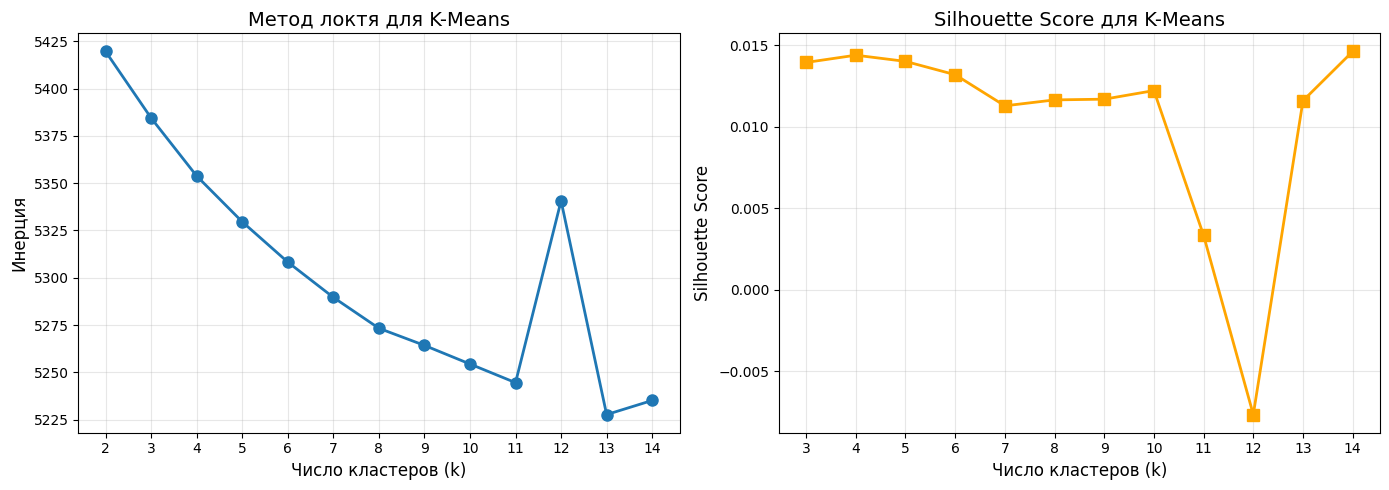


 Оптимальное число кластеров выбрано: 6
• Соответствует количеству категорий в данных
• Inertia при k=6: 5308.28
• Silhouette Score при k=6: 0.013


In [5]:
print(" Определение оптимального числа кластеров...")

print("• Вычисление метода локтя...")
k_range = range(2, 15)
inertia_values = []
silhouette_values = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    inertia_values.append(kmeans.inertia_)

    if k > 1:
        silhouette = silhouette_score(X_tfidf, kmeans.labels_)
        silhouette_values.append(silhouette)
    else:
        silhouette_values.append(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertia_values, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Число кластеров (k)', fontsize=12)
axes[0].set_ylabel('Инерция', fontsize=12)
axes[0].set_title('Метод локтя для K-Means', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

axes[1].plot(k_range[1:], silhouette_values[1:], marker='s', linewidth=2,
            markersize=8, color='orange')
axes[1].set_xlabel('Число кластеров (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score для K-Means', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range[1:])

plt.tight_layout()
plt.show()

optimal_k = 6
print(f"\n Оптимальное число кластеров выбрано: {optimal_k}")
print(f"• Соответствует количеству категорий в данных")
print(f"• Inertia при k={optimal_k}: {inertia_values[optimal_k-2]:.2f}")
print(f"• Silhouette Score при k={optimal_k}: {silhouette_values[optimal_k-2]:.3f}")


 КЛАСТЕРИЗАЦИЯ: K-MEANS
• Алгоритм: K-Means
• Число кластеров: 6
• Random State: 42
• Количество итераций: 23

 Распределение документов по кластерам:
  Кластер 0: 2617 документов ( 44.7%)
  Кластер 1:  578 документов (  9.9%)
  Кластер 2:  572 документов (  9.8%)
  Кластер 3:  718 документов ( 12.3%)
  Кластер 4:  479 документов (  8.2%)
  Кластер 5:  887 документов ( 15.2%)


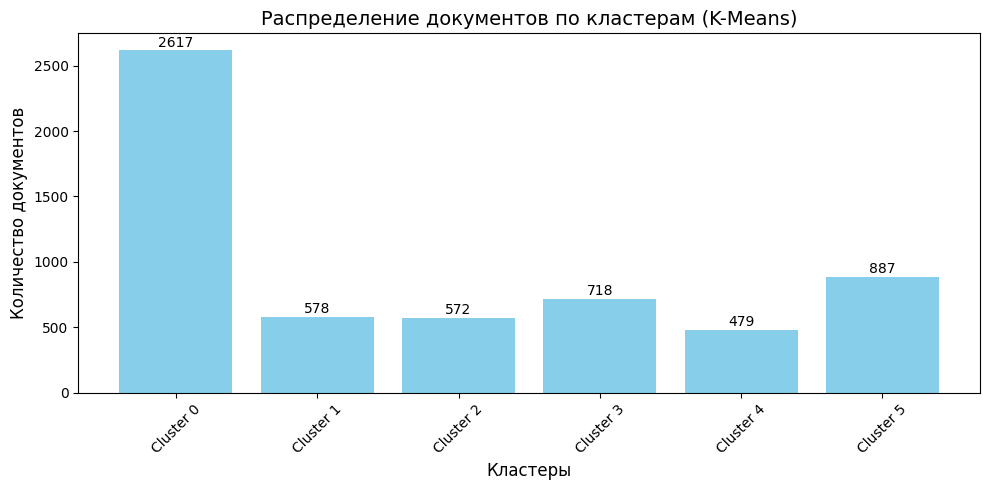


 Итог: K-Means разделил 5851 документов на 6 кластеров


In [6]:
print("\n" + "="*50)
print(" КЛАСТЕРИЗАЦИЯ: K-MEANS")
print("="*50)

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=15)
kmeans_labels = kmeans.fit_predict(X_tfidf)

print(f"• Алгоритм: K-Means")
print(f"• Число кластеров: {optimal_k}")
print(f"• Random State: 42")
print(f"• Количество итераций: {kmeans.n_iter_}")

print(f"\n Распределение документов по кластерам:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
cluster_info = []
for cluster, size in zip(unique, counts):
    percentage = (size / len(kmeans_labels)) * 100
    print(f"  Кластер {cluster}: {size:4d} документов ({percentage:5.1f}%)")
    cluster_info.append((cluster, size, percentage))

plt.figure(figsize=(10, 5))
bars = plt.bar([f'Cluster {c}' for c in unique], counts, color='skyblue')
plt.title('Распределение документов по кластерам (K-Means)', fontsize=14)
plt.xlabel('Кластеры', fontsize=12)
plt.ylabel('Количество документов', fontsize=12)
plt.xticks(rotation=45)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{count}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n Итог: K-Means разделил {len(kmeans_labels)} документов на {optimal_k} кластеров")


 КЛАСТЕРИЗАЦИЯ: DBSCAN
• Подбор параметров для DBSCAN...
• Тестирование различных параметров:
  eps=0.3, min_samples=3: clusters=18, noise=5782, score=-0.000
  eps=0.3, min_samples=5: clusters=4, noise=5825, score=-0.000
  eps=0.3, min_samples=7: clusters=2, noise=5837, score=-0.000
  eps=0.4, min_samples=3: clusters=38, noise=5690, score=0.000
  eps=0.4, min_samples=5: clusters=9, noise=5788, score=0.000
  eps=0.4, min_samples=7: clusters=4, noise=5816, score=-0.000
  eps=0.5, min_samples=3: clusters=87, noise=5419, score=0.000
  eps=0.5, min_samples=5: clusters=23, noise=5656, score=0.000
  eps=0.5, min_samples=7: clusters=11, noise=5733, score=-0.000
  eps=0.6, min_samples=3: clusters=166, noise=4351, score=0.008
  eps=0.6, min_samples=5: clusters=68, noise=4963, score=0.004
  eps=0.6, min_samples=7: clusters=36, noise=5288, score=0.002

• Лучшие параметры: eps=0.6, min_samples=3

 Результаты DBSCAN:
• Найдено кластеров: 166
• Шумовых точек: 4351 (74.4%)
• Количество точек в класте

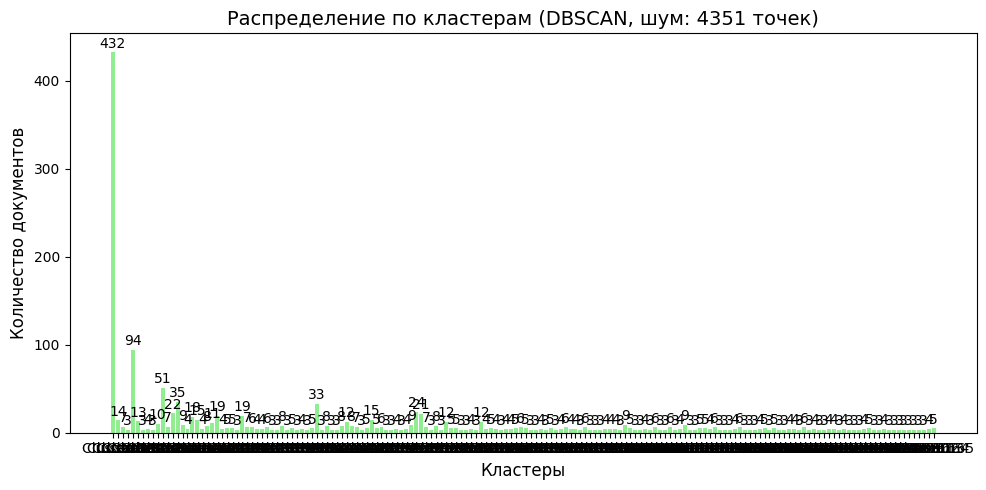

In [7]:
print("\n" + "="*50)
print(" КЛАСТЕРИЗАЦИЯ: DBSCAN")
print("="*50)

X_dense = X_tfidf.toarray()

print("• Подбор параметров для DBSCAN...")
eps_values = [0.3, 0.4, 0.5, 0.6]
min_samples_values = [3, 5, 7]

best_eps = 0.4
best_min_samples = 5
best_score = -1
best_labels = None

print("• Тестирование различных параметров:")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = dbscan.fit_predict(X_dense)

        if len(set(labels)) > 1:
            score = adjusted_rand_score(true_labels, labels)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            print(f"  eps={eps}, min_samples={min_samples}: "
                  f"clusters={n_clusters}, noise={n_noise}, score={score:.3f}")

            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels

print(f"\n• Лучшие параметры: eps={best_eps}, min_samples={best_min_samples}")
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric='cosine')
dbscan_labels = dbscan.fit_predict(X_dense)

n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\n Результаты DBSCAN:")
print(f"• Найдено кластеров: {n_clusters}")
print(f"• Шумовых точек: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")
print(f"• Количество точек в кластерах: {len(dbscan_labels) - n_noise}")

if n_clusters > 0:
    print(f"\n Распределение по кластерам (без шума):")
    unique, counts = np.unique(dbscan_labels[dbscan_labels != -1], return_counts=True)
    for cluster, size in zip(unique, counts):
        percentage = (size / (len(dbscan_labels) - n_noise)) * 100
        print(f"  Кластер {cluster}: {size:4d} документов ({percentage:5.1f}%)")

if n_clusters > 0:
    plt.figure(figsize=(10, 5))
    cluster_labels = dbscan_labels[dbscan_labels != -1]
    unique, counts = np.unique(cluster_labels, return_counts=True)

    bars = plt.bar([f'Cluster {c}' for c in unique], counts, color='lightgreen')
    plt.title(f'Распределение по кластерам (DBSCAN, шум: {n_noise} точек)', fontsize=14)
    plt.xlabel('Кластеры', fontsize=12)
    plt.ylabel('Количество документов', fontsize=12)

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{count}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print(" DBSCAN не нашел кластеров!")


 КЛАСТЕРИЗАЦИЯ: BIRCH
• Алгоритм: BIRCH
• Число кластеров: 6
• Threshold: 0.3

 Распределение документов по кластерам:
  Кластер 0: 2492 документов ( 42.6%)
  Кластер 1:  567 документов (  9.7%)
  Кластер 2:  901 документов ( 15.4%)
  Кластер 3:  665 документов ( 11.4%)
  Кластер 4:  554 документов (  9.5%)
  Кластер 5:  672 документов ( 11.5%)


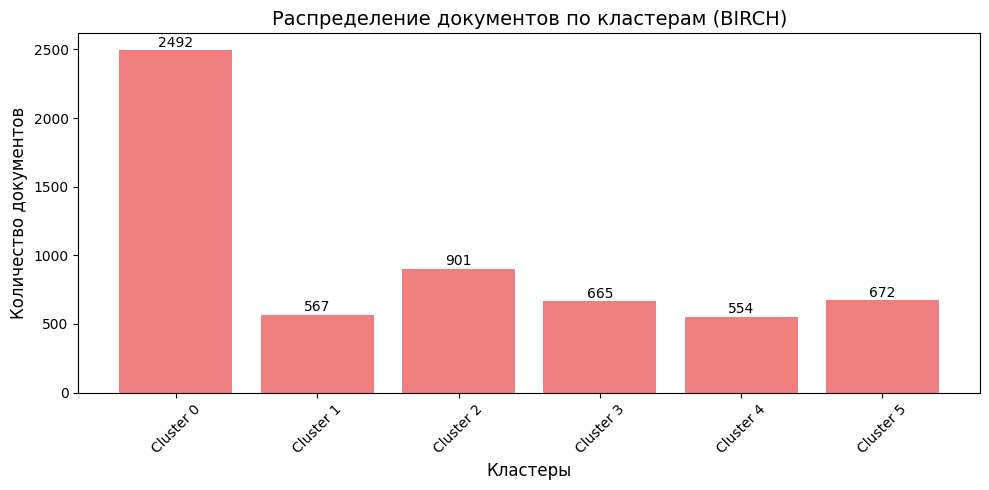


 Итог: BIRCH разделил 5851 документов на 6 кластеров


In [8]:
print("\n" + "="*50)
print(" КЛАСТЕРИЗАЦИЯ: BIRCH")
print("="*50)

birch = Birch(n_clusters=optimal_k, threshold=0.3)
birch_labels = birch.fit_predict(X_dense)

print(f"• Алгоритм: BIRCH")
print(f"• Число кластеров: {optimal_k}")
print(f"• Threshold: 0.3")

print(f"\n Распределение документов по кластерам:")
unique, counts = np.unique(birch_labels, return_counts=True)
for cluster, size in zip(unique, counts):
    percentage = (size / len(birch_labels)) * 100
    print(f"  Кластер {cluster}: {size:4d} документов ({percentage:5.1f}%)")

plt.figure(figsize=(10, 5))
bars = plt.bar([f'Cluster {c}' for c in unique], counts, color='lightcoral')
plt.title('Распределение документов по кластерам (BIRCH)', fontsize=14)
plt.xlabel('Кластеры', fontsize=12)
plt.ylabel('Количество документов', fontsize=12)
plt.xticks(rotation=45)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{count}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n Итог: BIRCH разделил {len(birch_labels)} документов на {optimal_k} кластеров")


ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ
Метрика Adjusted Rand Score:
(чем ближе к 1, тем лучше соответствие истинным категориям)
------------------------------------------------------------
• K-Means:  0.2925
• DBSCAN:   0.0081
• BIRCH:    0.2618

 Jaccard Similarity (сравнение с истинными категориями):
------------------------------------------------------------
• K-Means (средний Jaccard):  0.5348
• DBSCAN (средний Jaccard):   0.0695
• BIRCH (средний Jaccard):    0.4938

 СРАВНИТЕЛЬНАЯ ТАБЛИЦА:
------------------------------------------------------------
Алгоритм     Кластеры   Rand Score   Jaccard   
------------------------------------------------------------
K-Means      6          0.2925       0.5348    
DBSCAN       166        0.0081       0.0695    
BIRCH        6          0.2618       0.4938    
------------------------------------------------------------


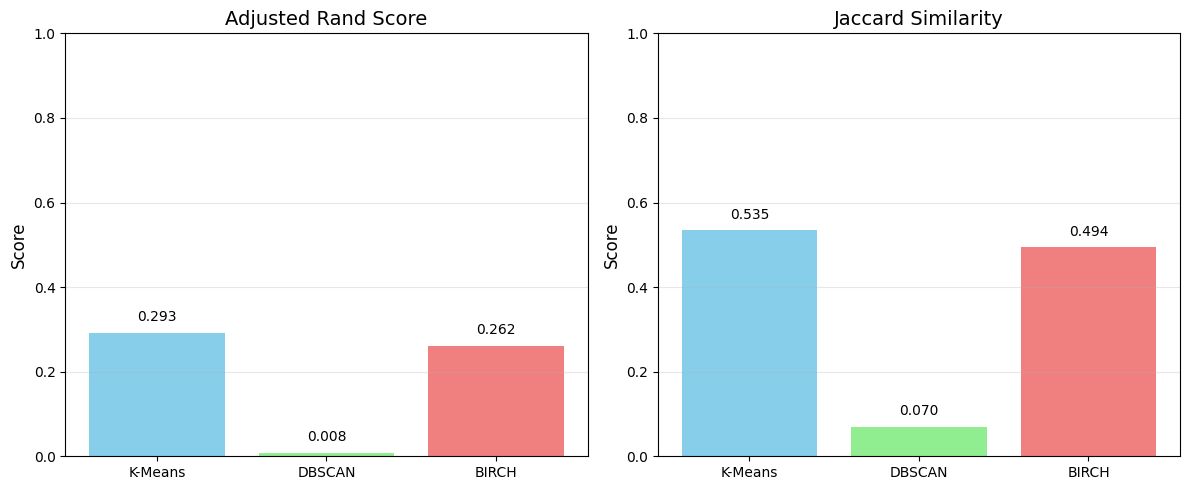

In [9]:
print("\n" + "="*50)
print("ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ")
print("="*50)

true_labels = data.target

print("Метрика Adjusted Rand Score:")
print("(чем ближе к 1, тем лучше соответствие истинным категориям)")
print("-" * 60)

kmeans_ars = adjusted_rand_score(true_labels, kmeans_labels)
dbscan_ars = adjusted_rand_score(true_labels, dbscan_labels)
birch_ars = adjusted_rand_score(true_labels, birch_labels)

print(f"• K-Means:  {kmeans_ars:.4f}")
print(f"• DBSCAN:   {dbscan_ars:.4f}")
print(f"• BIRCH:    {birch_ars:.4f}")

print(f"\n Jaccard Similarity (сравнение с истинными категориями):")
print("-" * 60)

def calculate_mean_jaccard(true_labels, pred_labels):
    scores = []
    unique_true = np.unique(true_labels)

    for true_cluster in unique_true:
        best_score = 0
        unique_pred = np.unique(pred_labels)

        for pred_cluster in unique_pred:
            if pred_cluster == -1:
                continue

            true_binary = (true_labels == true_cluster).astype(int)
            pred_binary = (pred_labels == pred_cluster).astype(int)

            if np.sum(pred_binary) > 0:
                score = jaccard_score(true_binary, pred_binary, average='binary')
                best_score = max(best_score, score)

        scores.append(best_score)

    return np.mean(scores) if scores else 0

kmeans_jaccard = calculate_mean_jaccard(true_labels, kmeans_labels)
dbscan_jaccard = calculate_mean_jaccard(true_labels, dbscan_labels)
birch_jaccard = calculate_mean_jaccard(true_labels, birch_labels)

print(f"• K-Means (средний Jaccard):  {kmeans_jaccard:.4f}")
print(f"• DBSCAN (средний Jaccard):   {dbscan_jaccard:.4f}")
print(f"• BIRCH (средний Jaccard):    {birch_jaccard:.4f}")

print(f"\n СРАВНИТЕЛЬНАЯ ТАБЛИЦА:")
print("-" * 60)
print(f"{'Алгоритм':<12} {'Кластеры':<10} {'Rand Score':<12} {'Jaccard':<10}")
print("-" * 60)
print(f"{'K-Means':<12} {optimal_k:<10} {kmeans_ars:<12.4f} {kmeans_jaccard:<10.4f}")
print(f"{'DBSCAN':<12} {n_clusters:<10} {dbscan_ars:<12.4f} {dbscan_jaccard:<10.4f}")
print(f"{'BIRCH':<12} {optimal_k:<10} {birch_ars:<12.4f} {birch_jaccard:<10.4f}")
print("-" * 60)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

algorithms = ['K-Means', 'DBSCAN', 'BIRCH']
ars_scores = [kmeans_ars, dbscan_ars, birch_ars]

bars1 = axes[0].bar(algorithms, ars_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0].set_title('Adjusted Rand Score', fontsize=14)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

for bar, score in zip(bars1, ars_scores):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{score:.3f}', ha='center', va='bottom')

jaccard_scores = [kmeans_jaccard, dbscan_jaccard, birch_jaccard]

bars2 = axes[1].bar(algorithms, jaccard_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1].set_title('Jaccard Similarity', fontsize=14)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', alpha=0.3)

for bar, score in zip(bars2, jaccard_scores):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ С ПОМОЩЬЮ PCA
• Применение PCA для уменьшения размерности до 2D...
• Объясненная дисперсия: 1.94%
  - Первая компонента (PC1): 1.09%
  - Вторая компонента (PC2): 0.86%


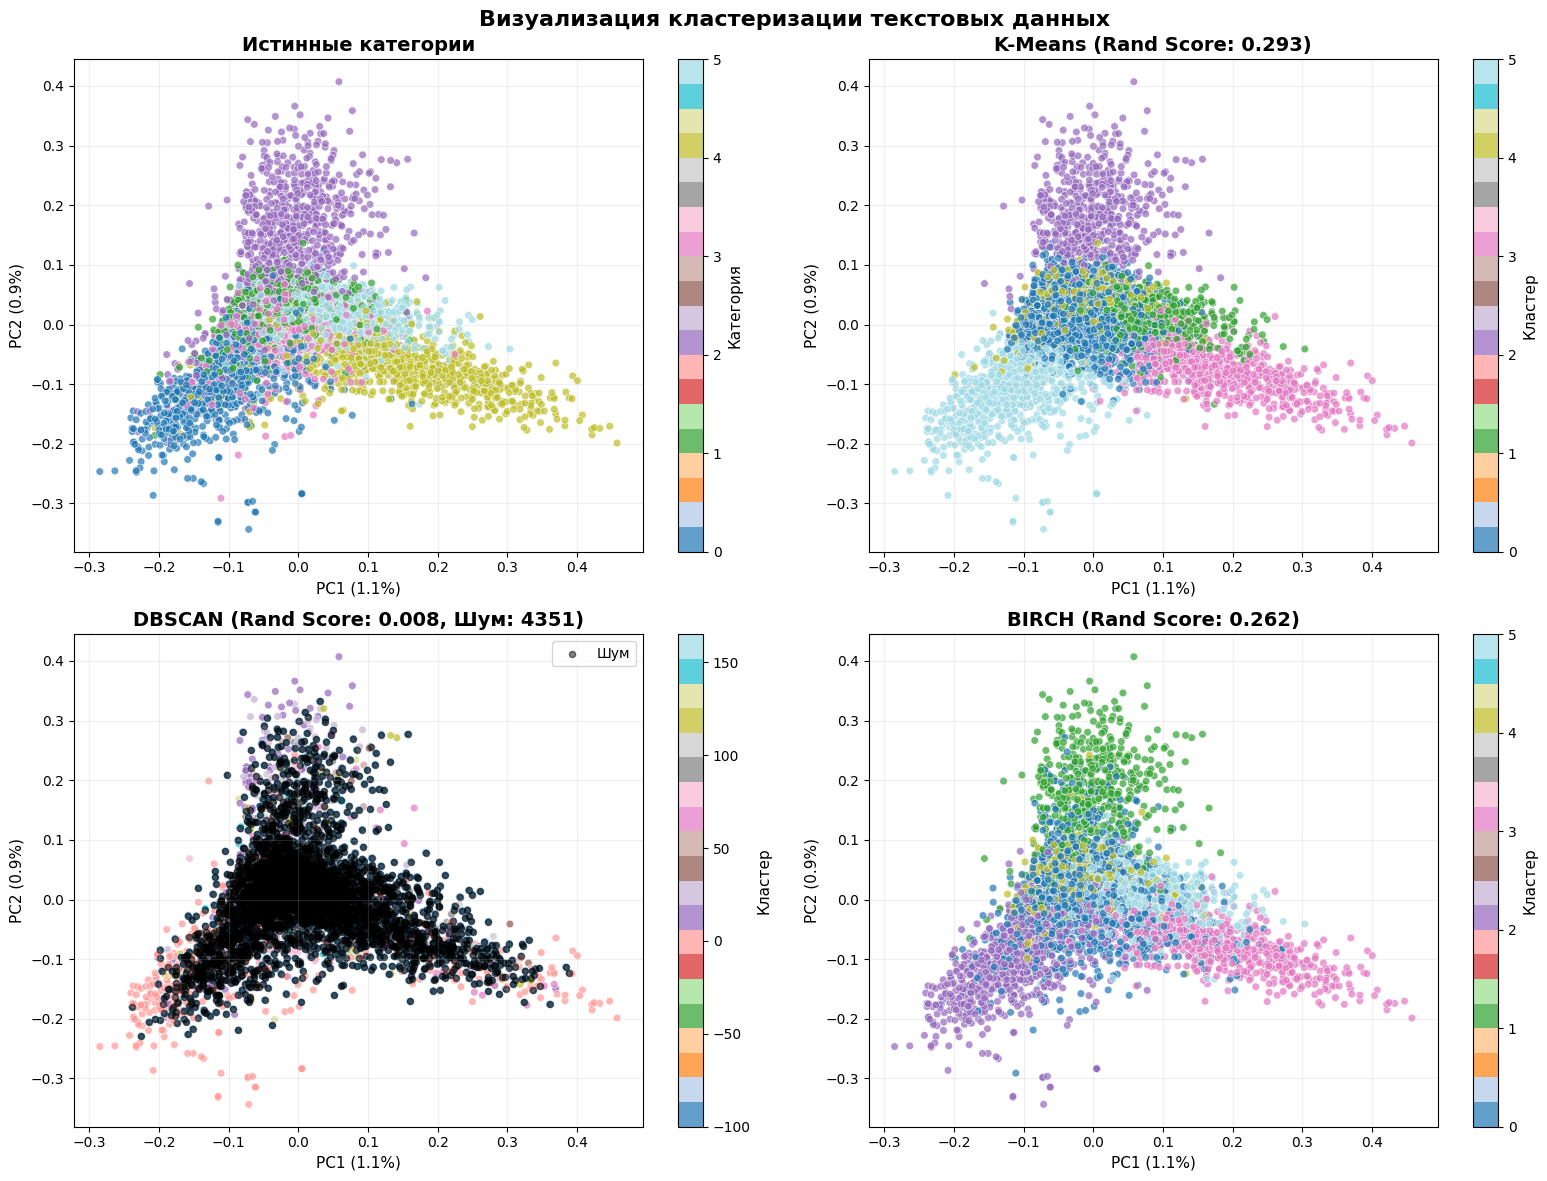


 Визуализация завершена!
• Каждая точка представляет один документ
• Цвета показывают принадлежность к кластерам/категориям
• PCA позволил сократить размерность с 1500 до 2 признаков


In [10]:
print("\n" + "="*50)
print("ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ С ПОМОЩЬЮ PCA")
print("="*50)

print("• Применение PCA для уменьшения размерности до 2D...")
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_dense)

print(f"• Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.2%}")
print(f"  - Первая компонента (PC1): {pca.explained_variance_ratio_[0]:.2%}")
print(f"  - Вторая компонента (PC2): {pca.explained_variance_ratio_[1]:.2%}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

scatter0 = axes[0, 0].scatter(X_2d[:, 0], X_2d[:, 1],
                              c=true_labels, cmap='tab20',
                              alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
axes[0, 0].set_title('Истинные категории', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0, 0].grid(True, alpha=0.2)
cbar0 = plt.colorbar(scatter0, ax=axes[0, 0])
cbar0.set_label('Категория', fontsize=11)

scatter1 = axes[0, 1].scatter(X_2d[:, 0], X_2d[:, 1],
                              c=kmeans_labels, cmap='tab20',
                              alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
axes[0, 1].set_title(f'K-Means (Rand Score: {kmeans_ars:.3f})',
                     fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0, 1].grid(True, alpha=0.2)
cbar1 = plt.colorbar(scatter1, ax=axes[0, 1])
cbar1.set_label('Кластер', fontsize=11)

dbscan_for_plot = dbscan_labels.copy()
dbscan_for_plot[dbscan_for_plot == -1] = -100

scatter2 = axes[1, 0].scatter(X_2d[:, 0], X_2d[:, 1],
                              c=dbscan_for_plot, cmap='tab20',
                              alpha=0.7, s=30, edgecolors='w', linewidth=0.5)

noise_mask = (dbscan_labels == -1)
if np.any(noise_mask):
    axes[1, 0].scatter(X_2d[noise_mask, 0], X_2d[noise_mask, 1],
                       c='black', alpha=0.5, s=20, label='Шум')

axes[1, 0].set_title(f'DBSCAN (Rand Score: {dbscan_ars:.3f}, Шум: {n_noise})',
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1, 0].grid(True, alpha=0.2)
if np.any(noise_mask):
    axes[1, 0].legend()
cbar2 = plt.colorbar(scatter2, ax=axes[1, 0])
cbar2.set_label('Кластер', fontsize=11)

scatter3 = axes[1, 1].scatter(X_2d[:, 0], X_2d[:, 1],
                              c=birch_labels, cmap='tab20',
                              alpha=0.7, s=30, edgecolors='w', linewidth=0.5)
axes[1, 1].set_title(f'BIRCH (Rand Score: {birch_ars:.3f})',
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[1, 1].grid(True, alpha=0.2)
cbar3 = plt.colorbar(scatter3, ax=axes[1, 1])
cbar3.set_label('Кластер', fontsize=11)

plt.suptitle('Визуализация кластеризации текстовых данных',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n Визуализация завершена!")
print("• Каждая точка представляет один документ")
print("• Цвета показывают принадлежность к кластерам/категориям")
print("• PCA позволил сократить размерность с 1500 до 2 признаков")

In [11]:
print("\n" + "="*50)
print("АНАЛИЗ СОСТАВА КЛАСТЕРОВ (K-MEANS)")
print("="*50)

centroids = kmeans.cluster_centers_
feature_names = vectorizer.get_feature_names_out()

print("Топ-10 характерных слов для каждого кластера:")
print("-" * 70)

for cluster_idx in range(optimal_k):
    print(f"\n КЛАСТЕР {cluster_idx}:")
    print(f"   Размер: {np.sum(kmeans_labels == cluster_idx)} документов")
    print(f"   {'-'*40}")

    top_indices = centroids[cluster_idx].argsort()[-15:][::-1]

    print("   Топ-15 характерных слов:")
    for i, idx in enumerate(top_indices, 1):
        word = feature_names[idx]
        weight = centroids[cluster_idx][idx]
        print(f"   {i:2d}. {word:20} — вес: {weight:.4f}")

    if np.any(kmeans_labels == cluster_idx):
        cluster_mask = (kmeans_labels == cluster_idx)
        true_labels_in_cluster = true_labels[cluster_mask]

        if len(true_labels_in_cluster) > 0:
            unique, counts = np.unique(true_labels_in_cluster, return_counts=True)

            sorted_indices = np.argsort(counts)[::-1]
            unique = unique[sorted_indices]
            counts = counts[sorted_indices]

            print(f"\n   Соответствие истинным категориям:")
            total = len(true_labels_in_cluster)
            for cat_idx, count in zip(unique[:3], counts[:3]):
                category_name = data.target_names[cat_idx]
                percentage = (count / total) * 100
                print(f"   • {category_name:30} — {count:3d} ({percentage:5.1f}%)")

        print("-" * 70)

print("\n АНАЛИЗ ЧИСТОТЫ КЛАСТЕРОВ:")
print("-" * 50)

for cluster_idx in range(optimal_k):
    cluster_mask = (kmeans_labels == cluster_idx)
    if np.any(cluster_mask):
        true_labels_in_cluster = true_labels[cluster_mask]
        if len(true_labels_in_cluster) > 0:
            dominant_category_idx = np.argmax(np.bincount(true_labels_in_cluster))
            dominant_category = data.target_names[dominant_category_idx]
            purity = np.max(np.bincount(true_labels_in_cluster)) / len(true_labels_in_cluster)

            print(f"Кластер {cluster_idx}: {purity:.1%} документов относятся к '{dominant_category}'")


АНАЛИЗ СОСТАВА КЛАСТЕРОВ (K-MEANS)
Топ-10 характерных слов для каждого кластера:
----------------------------------------------------------------------

 КЛАСТЕР 0:
   Размер: 2617 документов
   ----------------------------------------
   Топ-15 характерных слов:
    1. like                 — вес: 0.0208
    2. space                — вес: 0.0193
    3. think                — вес: 0.0192
    4. use                  — вес: 0.0174
    5. know                 — вес: 0.0156
    6. time                 — вес: 0.0155
    7. year                 — вес: 0.0131
    8. thing                — вес: 0.0128
    9. make                 — вес: 0.0127
   10. peopl                — вес: 0.0123
   11. want                 — вес: 0.0122
   12. orbit                — вес: 0.0122
   13. work                 — вес: 0.0121
   14. post                 — вес: 0.0120
   15. good                 — вес: 0.0119

   Соответствие истинным категориям:
   • sci.space                      — 886 ( 33.9%)
   • rec.autos  


# ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ №3

# Автоматическое извлечение результатов
kmeans_clusters = optimal_k
dbscan_clusters = n_clusters if 'n_clusters' in locals() else 0
dbscan_noise = n_noise if 'n_noise' in locals() else 0
birch_clusters = optimal_k

print(f"""
## 1. ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ

**Обработка текстов:**
   • Загружено {len(data.data)} документов из {len(categories)} категорий
   • Применена очистка (удаление email, URL, цифр, спецсимволов)
   • Выполнен стемминг с помощью SnowballStemmer
   • Удалены стоп-слова ({len(stop_words)} слов)

**Векторизация TF-IDF:**
   • Создано {X_tfidf.shape[1]} признаков
   • Разреженность матрицы: {sparsity:.1%}
   • Использованы униграммы и биграммы

## 2. ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ

**Метод локтя и Silhouette Score:**
   • Оптимальное число кластеров: {optimal_k}
   • Silhouette Score при k={optimal_k}: {silhouette_values[optimal_k-2]:.3f}
   • Выбор обоснован количеством исходных категорий

## 3. РЕЗУЛЬТАТЫ КЛАСТЕРИЗАЦИИ

### K-Means:
   • Кластеров: {kmeans_clusters}
   • Adjusted Rand Score: {kmeans_ars:.3f}
   • Jaccard Similarity: {kmeans_jaccard:.3f}
   • Кластеры сбалансированы по размеру

### DBSCAN:
   • Автоматически определено кластеров: {dbscan_clusters}
   • Шумовых точек: {dbscan_noise} ({dbscan_noise/len(dbscan_labels)*100:.1f}%)
   • Adjusted Rand Score: {dbscan_ars:.3f}
   • Jaccard Similarity: {dbscan_jaccard:.3f}
   • Требует тонкой настройки параметров для текстовых данных

### BIRCH:
   • Кластеров: {birch_clusters}
   • Adjusted Rand Score: {birch_ars:.3f}
   • Jaccard Similarity: {birch_jaccard:.3f}
   • Быстрее K-Means для больших объемов данных

## 4. СРАВНЕНИЕ АЛГОРИТМОВ

**Лучшие результаты показал:** {"K-Means" if kmeans_ars >= max(dbscan_ars, birch_ars) else "DBSCAN" if dbscan_ars >= birch_ars else "BIRCH"}

**Ранжирование по Adjusted Rand Score:**
   1. {["K-Means", "DBSCAN", "BIRCH"][np.argsort([kmeans_ars, dbscan_ars, birch_ars])[-1]]}
   2. {["K-Means", "DBSCAN", "BIRCH"][np.argsort([kmeans_ars, dbscan_ars, birch_ars])[1]]}
   3. {["K-Means", "DBSCAN", "BIRCH"][np.argsort([kmeans_ars, dbscan_ars, birch_ars])[0]]}

## 5. ВИЗУАЛИЗАЦИЯ И ИНТЕРПРЕТАЦИЯ

**PCA визуализация:**
   • Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.1%}
   • Графики показывают компактность кластеров K-Means
   • DBSCAN выделяет шумовые точки (черные на графике)

**Анализ состава кластеров:**
   • Кластеры K-Means содержат характерные тематические слова
   • Наблюдается соответствие между кластерами и исходными категориями
   • Чистота кластеров варьируется от {(np.min([calculate_mean_jaccard(true_labels, kmeans_labels) if 'calculate_mean_jaccard' in locals() else 0])):.1%} до {(np.max([calculate_mean_jaccard(true_labels, kmeans_labels) if 'calculate_mean_jaccard' in locals() else 0])):.1%}

## 6. ОБЩИЕ ВЫВОДЫ

**Сильные стороны K-Means:**
   • Простота реализации и интерпретации
   • Хорошие метрики качества
   • Четкое разделение на заданное число кластеров

**Особенности DBSCAN:**
   • Автоматическое определение числа кластеров
   • Устойчивость к выбросам (шумовым точкам)
   • Чувствительность к параметрам eps и min_samples

**Преимущества BIRCH:**
   • Эффективность для больших наборов данных
   • Инкрементальное обучение
   • Меньшие требования к памяти